In [1]:
pwd

'/Users/banjo/Projects/nll_pnsn/scripts'

In [2]:
import os
import sys
import glob
import pandas as pd
import numpy as np
from obspy import read
from obspy.core import UTCDateTime

In [3]:
path='/Users/banjo/Projects/nll_pnsn/NLLoc/util'
ifile = '/pnsn_in_CVM.hypo'
# ifile='/kirkland.hypo' 
# ifile='/evid_61535372.hypo'

# ifile='/brem4.9.hypo' 


# 
# ofile='evid_61536022.out' 
# stn_file='evid_61536022_stnInfo.out'
# g2t_stn_list='/Users/banjo/Projects/nll_pnsn/NLLoc/util/kirkland_stns.csv'
# g2t_stn_list='/Users/banjo/Projects/nll_pnsn/NLLoc/util/brem4.9_stns.csv'

# g2t_stn_list='/Users/banjo/Projects/nll_pnsn/NLLoc/util/brem_stns.csv'


# g2t_stn_list4plot='/Users/banjo/Projects/nll_pnsn/util/stationInfo/61535372_stations.csv'
# g2t_stn_list4plot='/Users/banjo/Projects/nll_pnsn/util/stationInfo/kirkland_stations.csv'


datum=0

In [4]:
os.chdir(path)
ID=1
i=1
column = ['ID','TIME','LAT','LON','DEP','MAG','MTYPE','EH','EZ','RMS','EVID']
stacol = ['NET','STA','CHAN']
eveinfo = pd.DataFrame(columns=column)
nets = []
stas = []
chan =[]
#    stainfo = ['STA','ARR','ABSA','WEI','PHA','MOT','ON','DIR']
#     stainfo = ['STA','ARR','PHA']
stainfo = ['EVID','STA','ARR','PHA']

tempsta = pd.DataFrame(columns = stainfo)
arrinfo = []
with open(path+ifile,'r') as fp:
    for line in fp.readlines():
        i=i+1
        if len(line) == 180:
            year = line[0:4]
            month = line[4:6]
            day = line[6:8]
            hour = line[8:10]
            minu = line[10:12]
            sec = line[12:16][:-2]+'.'+line[12:16][-2:]
            ddir = year+'.'+month+'.'+day+'.'+hour+'.'+minu+'.'+line[12:16][:-2]
            EVID= line[136:146].strip()
            time = year+'-'+month+'-'+day+'T'+hour+':'+minu+':'+sec
            time = UTCDateTime(time)
            lat = float(line[16:18]) + float(line[19:23][:-2]+'.'+line[19:23][-2:].replace(' ','0'))/60.0
            lon = -(float(line[23:26]) + float(line[27:31][:-2]+'.'+line[27:31][-2:].replace(' ','0'))/60.0)
            dep = line[31:36]
            if dep[-2]=='-':
                dep = dep[:-1]+'.0'+dep[-1:]
            else:
                dep = (dep[:-2]+'.'+dep[-2:].replace(' ','0'))
            dep = float(dep)+datum
            rms = float((line[48:52][:-2]+'.'+line[48:52][-2:]).replace(' ','0'))
            eh = float((line[85:89][:-2]+'.'+line[85:89][-2:]).replace(' ','0'))
            ez = float((line[89:93][:-2]+'.'+line[89:93][-2:]).replace(' ','0'))
            mc = line[70:73].strip()
            mtype = line[122]
            if len(mc)!= 0 and mc[0]=='-':
                mag = float(mc[:2]+'.'+mc[-1])
            elif len(mc)!=0 and mc[0]!='-':
                mag = float(mc[:-2]+'.'+mc[-2:])
            else:
                mag = -5 #coda magnitude
            newRow = {'ID':int(ID),'TIME':time,'LAT':lat,'LON':lon,'DEP':dep,
                      'MAG':mag,'MTYPE':mtype,'EH':eh,'EZ':ez,
                      'RMS':rms,'EVID':EVID,'DIR':ddir}
            eveinfo = eveinfo.append(newRow,ignore_index=True)
            tempsta = tempsta.sort_values(by='ARR')
            arrinfo.append(tempsta)
            tempsta = pd.DataFrame(columns = stainfo)
            ID=ID+1
        elif len(line) == 121 or len(line)==120:
            sta = line[:5].strip()
            if sta not in stas:
                stas.append(sta)
                nets.append(line[5:7].strip())
                chan.append(line[9:12])
            
            #pull out the P phase
            pha = line[14]
            mot = line[15]
            onset = line[13]
            if pha != ' ' and (line[11] == 'Z' or line[11] == '3'):
                arryear = line[17:21]
                arrmonth = line[21:23]
                arrday = line[23:25]
                arrhour = line[25:27]
                arrmin = line[27:29]
                arrsec = (line[30:34][:-2]+'.'+line[30:34][-2:]).replace(' ','0')
                if float(arrsec) >= 60.0:
                    arrsec = float(arrsec)-60.0
                    arrtime = arryear+'-'+arrmonth+'-'+arrday+'T'+arrhour+':'+arrmin+':'+str(arrsec)
                    arrtime = UTCDateTime(arrtime)+60.0
                else:
                    arrtime = arryear+'-'+arrmonth+'-'+arrday+'T'+arrhour+':'+arrmin+':'+arrsec
                    arrtime = UTCDateTime(arrtime)
                PTT = arrtime - time
                pweight = int(line[16])
                rpw = pweight
                newStap = {'EVID':EVID,'STA':sta,'ARR':PTT,'PHA':pha}
#                 newStap = {'STA':sta,'WEI':rpw,'ARR':PTT,'PHA':pha,'ABSA':arrtime,'MOT':mot,'ON':onset}
                tempsta = tempsta.append(newStap,ignore_index=True)

    
            else:
                 print ('Not avaliable P phase, not use in here')
            spha = line[47]
            if spha == 'S':
                arryear = line[17:21]
                arrmonth = line[21:23]
                arrday = line[23:25]
                arrhour = line[25:27]
                arrmin = line[27:29]
                arrsec = (line[42:46][:-2]+'.'+line[42:46][-2:]).replace(' ','0')
                if float(arrsec) >= 60:
                    arrsec = float(arrsec)-60.0
                    arrtime = arryear+'-'+arrmonth+'-'+arrday+'T'+arrhour+':'+arrmin+':'+str(arrsec)
                    arrtime = UTCDateTime(arrtime)+60.0
                else:
                    arrtime = arryear+'-'+arrmonth+'-'+arrday+'T'+arrhour+':'+arrmin+':'+arrsec
                    arrtime = UTCDateTime(arrtime)
                STT = arrtime - time
                if STT < 0.0:
                    print ("i-1")
                    sys.exit('origin time %s and arrival time %s'%(time,arrtime))
                swei = int(line[49])
                rsw = swei
                newStas = {'EVID':EVID,'STA':sta,'ARR':STT,'PHA':spha}
#                 newStas = {'STA':sta,'WEI':rsw,'ARR':STT,'PHA':spha,'ABSA':arrtime}
                tempsta = tempsta.append(newStas,ignore_index=True)

        else:
            print ("End line for eq. %s: %d'%(EVID,i-1)")

arrinfo.append(tempsta)

arrinfo.pop(0)
# arrdf = pd.DataFrame(arrinfo)
eveinfo['ARR']=arrinfo
#     test = 
stainfos = pd.DataFrame(np.transpose([nets,stas,chan]),columns=stacol)

# print(stainfos)
# print(arrinfo)

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EV

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, no

End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
End line for eq. %s: %d'%(EVID,i-1)
Not avaliable P phase, not use in here
End lin

ValueError: could not convert string to float: '-1..'

In [5]:
arr = arrinfo[0]
arr
# arr.head(50)
# arr.drop(arr.loc[arr['ARR'] == 0.0].index, inplace=True)
# arr.drop(arr.loc[arr['PHA'] == 'S'].index, inplace=True)
# arr.drop(arr.loc[arr['WEI'] >= 5].index, inplace=True)
# cat.drop(cat.loc[cat['Lon'] < -40].index , inplace=True)
# arr = arrinfo[0]['ARR'].values

,EVID,STA,ARR,PHA


In [6]:
# arr.sort_values('WEI')
# arr.describe()

,EVID,STA,ARR,PHA,ABSA,WEI
0,NaN,BLN,16.22,S,1996-12-01T13:43:26.540000Z,0.0
1,NaN,SMW,19.87,S,1996-12-01T13:43:30.190000Z,0.0


In [7]:
arr.sort_values('ARR')
stations = arr.STA

In [8]:
# df.to_csv('/Users/banjo/Projects/nll_pnsn/util/catalogs/brem.cat', index=0)

In [38]:
eveinfo.ARR[5]

,EVID,STA,ARR,PHA
6,10420473,PGW,5.05,P
8,10420473,SPW,5.67,P
7,10420473,RMW,10.24,P
2,10420473,HTW,10.63,P
5,10420473,OHW,23.14,S
0,10420473,BOW,38.59,S
3,10420473,MBW,40.49,S
4,10420473,NAC,47.27,S
1,10420473,ELL,51.12,S


In [45]:
list = []
for i in range(len(eveinfo.ARR)):
    group = eveinfo.ARR[i]
    group = np.array(group)
#     id = str(np.min(group.EVID))
#     df = pd.DataFrame(group)
#     print(group)
    list.append(group)
#     df.to_csv(id+'.csv')

In [48]:
list

[array([['10408683', 'BLN', 16.22, 'S'],
        ['10408683', 'SMW', 19.87, 'S']], dtype=object),
 array([['10420133', 'GMW', 3.05, 'P'],
        ['10420133', 'GNW', 3.32, 'P'],
        ['10420133', 'PS0', 4.54, 'P'],
        ['10420133', 'KD0', 4.66, 'P'],
        ['10420133', 'KD0', 4.78, 'P'],
        ['10420133', 'PGW', 4.79, 'P'],
        ['10420133', 'BG0', 4.96, 'P'],
        ['10420133', 'SPW', 5.35, 'P'],
        ['10420133', 'HDW', 6.06, 'P'],
        ['10420133', 'GNW', 6.44, 'S'],
        ['10420133', 'BHW', 8.18, 'P'],
        ['10420133', 'MEW', 8.38, 'P'],
        ['10420133', 'BLN', 8.54, 'P'],
        ['10420133', 'KD0', 9.37, 'S'],
        ['10420133', 'RMW', 10.09, 'P'],
        ['10420133', 'HTW', 10.48, 'P'],
        ['10420133', 'GHW', 10.64, 'P'],
        ['10420133', 'TTW', 10.77, 'P'],
        ['10420133', 'SMW', 10.96, 'P'],
        ['10420133', 'GSM', 12.23, 'P'],
        ['10420133', 'OHW', 12.74, 'P'],
        ['10420133', 'CPW', 13.12, 'P'],
        ['1042

In [6]:
stainfos

NameError: name 'stainfos' is not defined

In [11]:
# stations = np.unique(stainfos['STA'].values)

In [12]:
df2 = pd.DataFrame(stations, columns =['stn'])

In [13]:
# for i in range(len(stations)):
#     sta = stations[i]
#     stainfo 
#     print(sta)

In [14]:
path2 = '/Users/banjo/Projects/nll_pnsn/util/stationInfo'
df1 = pd.read_csv(path2 + '/pnsnStations_simple.list')
# df2 = pd.read_csv(path + '/p4_stations_for_test.list')


In [15]:
match_sta = []
match_lat =[]
match_lon=[]
match_ele=[]
# tmp = df2['stn'].values
tmp = stations.values
for i in range(len(tmp)):
    station = tmp[i]
    match = df1.loc[df1['sta']==station].values[0]
    match_lat.append(match[3])
    match_lon.append(match[4])
    match_ele.append(match[5])
    match_sta.append(match[1])

In [16]:
df = pd.DataFrame(list(zip(match_sta,match_lat,match_lon,match_ele)),columns = ['Station','Lat','Lon','Elev'])

In [17]:
df.drop_duplicates()

,Station,Lat,Lon,Elev
0,BLN,48.006624,-122.97265,601
1,SMW,47.319450,-123.34445,877


In [18]:
srcs = []
descriptor = []
zeros = []
lats = []
lons = []
elvs = []
names=[]
for i in range(len(match_lat)):
    lat = match_lat[i]
    lat = '%7.4f' %lat
    lon = match_lon[i]
    lon = '%7.4f' %lon
    ele = match_ele[i]/1000
    ele = '%6.2f' %ele
    name = match_sta[i]
    name = '%5s' %name
    name = str(name)
    srcs.append('GTSRCE')
    descriptor.append('LATLON')
    zeros.append('0.0')
    lats.append(lat)
    names.append(name)
    lons.append(lon)
    elvs.append(ele)

In [19]:
df = pd.DataFrame(list(zip(srcs,names,descriptor,lats,lons,zeros,elvs)),columns = ['Source','Station','Descriptor','Lat','Lon','Zeros','Elev'])

In [20]:
df = df.drop_duplicates()

In [21]:
# df.to_csv(g2t_stn_list4plot,index=0)

In [22]:
df.sort_values('Station')

,Source,Station,Descriptor,Lat,Lon,Zeros,Elev
0,GTSRCE,BLN,LATLON,48.0066,-122.9727,0.0,0.60
1,GTSRCE,SMW,LATLON,47.3195,-123.3444,0.0,0.88


In [23]:
df.to_csv(g2t_stn_list,sep =' ',index=0,header=False)

In [24]:
# df

In [25]:
lat = df['Lat'].values

In [26]:
lon = df['Lon'].values

In [27]:
np.max(lon),np.min(lon) #,np.max(lat),np.min(lat)

('-123.3444', '-122.9727')

In [28]:
np.max(lat) ,np.min(lat)

('48.0066', '47.3195')

In [50]:
list = pd.read_csv('/Users/banjo/Projects/nll_pnsn/scripts/list')

In [51]:
list

,q,id,stn,tt,ph,x
0,NaN,10408683,BLN,16.22,S,NaN
1,NaN,10408683,SMW,19.87,S,NaN
2,NaN,10420133,GMW,3.05,P,NaN
3,NaN,10420133,GNW,3.32,P,NaN
4,NaN,10420133,PS0,4.54,P,NaN
...,...,...,...,...,...,...
7156,NaN,61706761,GNW,8.02,S,NaN
7157,NaN,61706761,GNW,4.47,P,NaN
7158,NaN,61706761,HDW,6.73,P,NaN
7159,NaN,61706761,HDW,12.10,S,NaN


In [64]:
stn = list.stn
stns = np.unique(stn)
stns

array(['7030', '7040', 'ALCT', 'ALKI', 'ALLI', 'ASR', 'ATES', 'AUG',
       'B001', 'B005', 'B006', 'B007', 'B013', 'B014', 'B017', 'B018',
       'B05D', 'B201', 'B941', 'B943', 'BABE', 'BBO', 'BECK', 'BELF',
       'BEN', 'BERY', 'BES3', 'BES4', 'BES5', 'BEVT', 'BG0', 'BHW', 'BLDG',
       'BLN', 'BM0', 'BOW', 'BPO', 'BRAV', 'BRGL', 'BRKS', 'BRPT', 'BRV',
       'BSFP', 'BVW', 'C04A', 'CARB', 'CBS', 'CDF', 'CDMR', 'CINE', 'CMM',
       'CMW', 'COR', 'CPW', 'CRBN', 'CRF', 'CTR', 'CWFG', 'D03D', 'D04E',
       'DBO', 'DONK', 'DOSE', 'DPW', 'DY2', 'EARN', 'EDM', 'EGRN', 'ELK',
       'ELL', 'ELW', 'EPH', 'ERW', 'ET3', 'ETW', 'EVCC', 'EVGW', 'FHE',
       'FINN', 'FL2', 'FMW', 'GBB', 'GBL', 'GHW', 'GL2', 'GLK', 'GMO',
       'GMW', 'GNW', 'GPW', 'GRCC', 'GRE', 'GRIF', 'GSM', 'GTWN', 'GTWY',
       'GUL', 'HART', 'HBO', 'HDW', 'HEBO', 'HICC', 'HOG', 'HOLY', 'HOMA',
       'HSO', 'HSR', 'HTW', 'JBO', 'JCW', 'JUN', 'KCAM', 'KD0', 'KDK',
       'KEYP', 'KICC', 'KIMB', 'KIMR', 'KINR', 'KITP',

In [60]:
# list.stn.str.count("NINO").sum()

4

In [133]:
stn_count=[]
for i in range(len(stns)):
    stn = str(stns[i])
    count = list.stn.str.count(stn).sum()
#     print(stn,count)
    stn_count.append([stn,count])

In [134]:
df=pd.DataFrame(stn_count,columns=['stn','count'])
# arr.drop(arr.loc[arr['ARR'] == 0.0].index, inplace=True)
df.sort_values('count')
df.drop(df.loc[df['count']<=30].index,inplace=True)
# df.sort_values('count')
df.describe()

,count
count,56.000000
mean,92.303571
std,93.351519
min,31.000000
25%,40.750000
50%,51.000000
75%,110.000000
max,466.000000


In [135]:
# df.hist('count')

In [136]:
import matplotlib.pyplot as plt

[None, None, None]

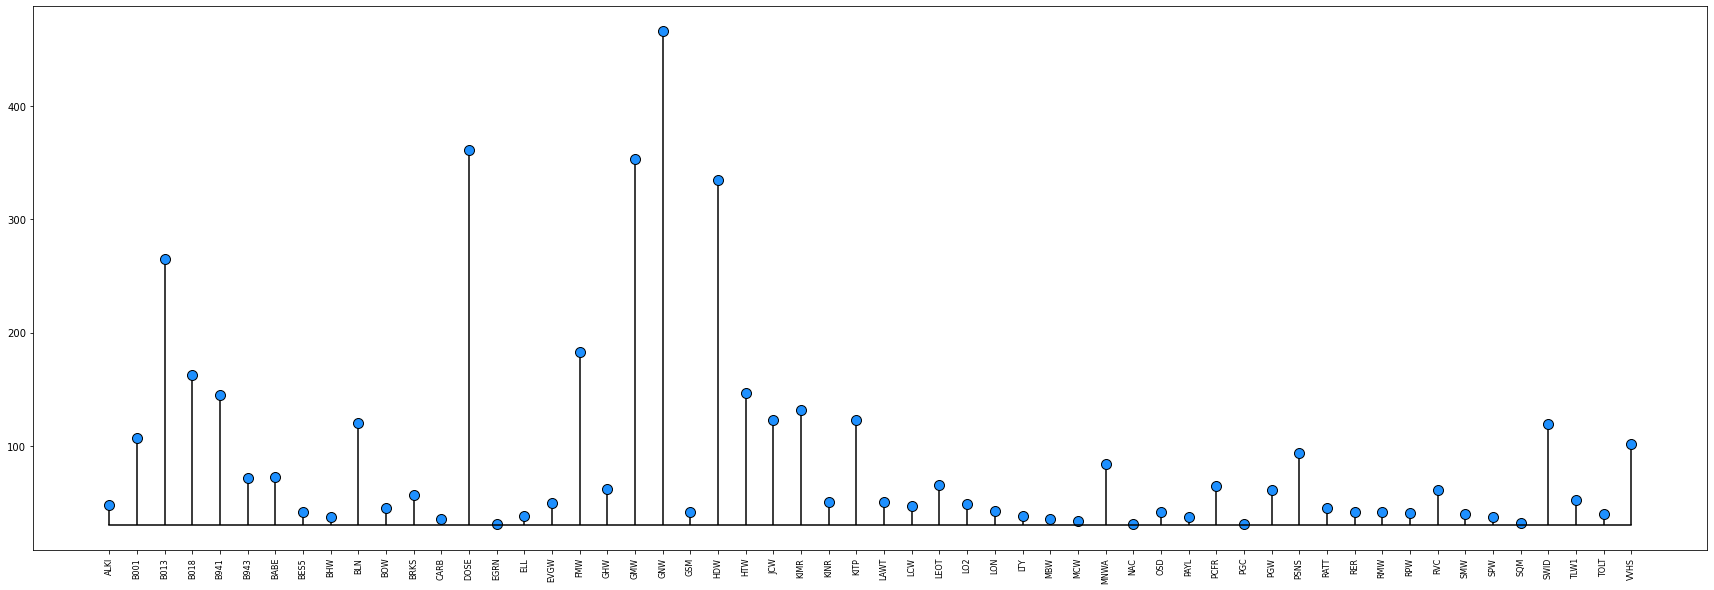

In [137]:
plt.figure(figsize=(30,10))
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=8)
# plt.stem(df['count'],basefmt= 50)
(markers, stemlines, baseline) = plt.stem(df['stn'],df['count'], bottom=30,linefmt='k',basefmt='k')
markers.set_markerfacecolor('dodgerblue')
ax.tick_params(axis='x', rotation=90.0)
# markers.set_markerfacecolor='r'
plt.setp(markers,markersize=10, markeredgecolor="k", markeredgewidth=1)

In [140]:
df.stn

3      ALKI
8      B001
12     B013
15     B018
18     B941
19     B943
20     BABE
28     BES5
31      BHW
33      BLN
35      BOW
39     BRKS
45     CARB
62     DOSE
67     EGRN
69      ELL
76     EVGW
80      FMW
83      GHW
87      GMW
88      GNW
93      GSM
99      HDW
107     HTW
109     JCW
117    KIMR
118    KINR
119    KITP
125    LAWT
128     LCW
130    LEOT
133     LO2
135     LON
137     LTY
145     MBW
147     MCW
152    MNWA
157     NAC
181     OSD
188    PAYL
190    PCFR
192     PGC
193     PGW
205    PSNS
210    RATT
216     RER
218     RMW
220     RPW
224     RVC
241     SMW
245     SPW
246     SQM
256    SWID
265    TLW1
266    TOLT
289    VVHS
Name: stn, dtype: object